# Resizing & Image Interpolation

****

**Image Resizing using the Averaging Method (Downsampling)**. The averaging method involves taking the average value of a group of pixels and then using this average value to represent those pixels. In the context of image processing, when we refer to "averaging," we're typically talking about averaging the intensity values of a group of neighboring pixels.

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def resize_with_averaging(img, target_height, target_width):
    # Get the dimensions of the source image
    source_height, source_width, channels = img.shape
    
    # Calculate the scaling factors
    height_scale = source_height / target_height
    width_scale = source_width / target_width
    
    # Create an empty array for the resized image
    resized_image = np.zeros((target_height, target_width, channels))
    
    for y in range(target_height):
        for x in range(target_width):
            # Determine the source pixels that fall into this target pixel
            start_y = int(y * height_scale)
            end_y = int((y + 1) * height_scale)
            start_x = int(x * width_scale)
            end_x = int((x + 1) * width_scale)
            
            # Average those pixels
            resized_image[y, x] = np.mean(img[start_y:end_y, start_x:end_x], axis=(0, 1))
            
    return resized_image.astype(np.uint8)


(200, 200, 3)
(100, 100, 3)


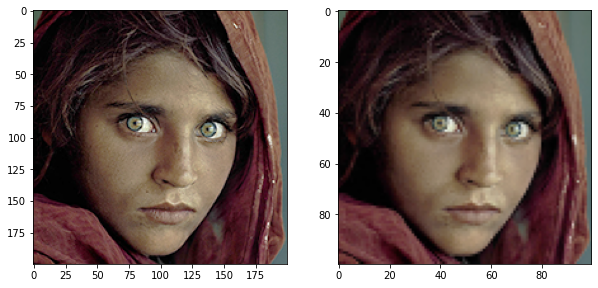

In [10]:
img = cv2.imread("../Graphics/face.png")    

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print(img.shape)

img_average = resize_with_averaging(img, 100, 100)

print(img_average.shape)

# Plot the images next to each other. make the figure large
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(img_average)

plt.show()



**Interpolation** is a method of constructing (finding) new data points based on the range of a discrete set of known data points. In image processing we are filling in the gaps in our pixel data when resize the image.  Either adding pixels when the image is upsized or removing them when it is downsized.  Information is always lost when a resizing occurs, interpolation tries to make the best guess to fill in the gaps from the lost data.

<img src="../Graphics/interpolation.png"><p>

#### How do we fill in the missing values?  Let's start with finding points along a line and build from there.

### Linear Interpolation

<b>Linear interpolation</b> is a method of using linear polynomials to construct new data points within the range of a discrete set of known data points.
<p>
Formula: <p>
y = y<sub>1</sub> + (((x - x<sub>1</sub>) * (y<sub>2</sub> - y<sub>1</sub>)) / (x<sub>2</sub> - x<sub>1</sub>)) <p>

So to find a point on the line. Given,

(x1,y1) = (1,4)

(x2,y2) = (6,9)

x = 5

From Linear Interpolation formula,

y = y<sub>1</sub> + (((x - x<sub>1</sub>) * (y<sub>2</sub> - y<sub>1</sub>)) / (x<sub>2</sub> - x<sub>1</sub>)) <p>

y = 4+(((5-1) x (9-4))/(6-1))

   = 4+((4×5)/5)

   = 4+(20/5)

   = 4+4

   = 8

So new data point (x, y) is (5,8)


<p>

A simple way to think about linear interpolation is a weighting of the known data points by their distance to the unknown intermediate points.<p>
<img src="../Graphics/lerp.png"><p>

We have already used interpolation with the HSV color space to set the values to the correct range.  Remember: ```` np.interp() ````

Let's go through three algorithms for resizing images.  Each has it's advantages and disadvantages. 



### Nearest Neighbor

The nearest neighbor algorithm selects the value of the nearest point and does not consider the values of neighboring points at all.  A very simple algorithm with a fast execution time widely used in real-time rendering.  Nearest Neighbor produces sharp edges and is ideal for images with hard lines.<p>
<img src="../Graphics/nn_1.png">
<p><p>


#### Nearest Neighbor Pseudoscope
<img src="../Graphics/grid-nn.png"><p>
````
If (K-B < B+1-K)

    Pixel is one of the top two.

Else

    Pixel is one of the bottom two.

ENDIF

IF (J-A < A+1-J)

    Pixel is one of the left two.

Else 

    Pixel is one of the right two.

ENDIF
````




(150, 150)


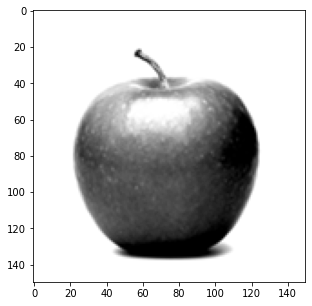

In [18]:
# CODE FOR NN ALGO

import numpy as np
import cv2
import matplotlib.pyplot as plt

# NEarest Neighbor Algorithm
def NN_interpolation(img, scale_factor):
    # Get the dimensions of the image
    height = img.shape[0]
    width = img.shape[1]

    # Calculate the new dimensions of the image
    new_height = int(height * scale_factor)
    new_width = int(width * scale_factor)
    # Create a new image of the new dimensions
    new_img = np.zeros((new_height, new_width), dtype=np.uint8)
    # Calculate the scaling factor
    scale_x = width / new_width
    scale_y = height / new_height
    # Loop through the new image and find the nearest neighbor in the original image
    for y in range(0,new_height):
        for x in range(0,new_width):
            # Calculate the coordinates of the nearest neighbor in the original image
            x0 = int(x * scale_x)
            y0 = int(y * scale_y)
            # Assign the pixel value to the new image
            new_img[y, x] = img[y0, x0]
    return new_img

#Saving the image in a variable
img = cv2.imread('Graphics/apple.png')

#OpenCV by defualt uses BGR instead of RGB.  Old digital camera standard.
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print(img.shape)

# Set the size of the plot.
fig = plt.figure(figsize = (5,5))

#Use matplotlib while using a python notebook. Draw the image.
plt.imshow(img, cmap='gray')


(600, 600)


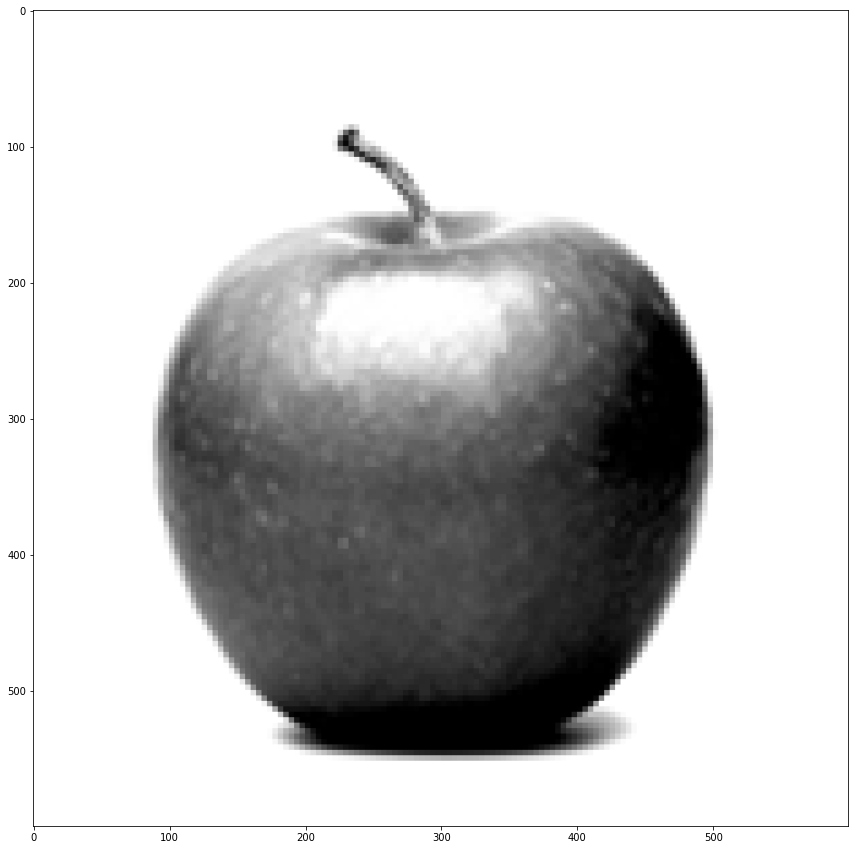

In [19]:
img_NN = NN_interpolation(img, 4)
print(img_NN.shape)

# Set the size of the plot.
fig = plt.figure(figsize = (15,15))
#Use matplotlib while using a python notebook. Draw the image.
plt.imshow(img_NN, cmap='gray')

### Bi-Linear Interpolation

We already went over to to Linear Interpolation along a 1-D line but how do we accomplish the same interpolation for our 2-D image.<p>

Instead of a set of two known data points we now have a set of four known data points. <p>

Given, 4 pixels (0,0), (1,0), (0,1), and (1,1).<br>

What is the value at (0.3,0.4)

<img src="../Graphics/BiLinear_1.png"> <p>
<ol>
<li>First, find the value along rows i.e at position A:(0,0.4) and B:(1,0.4) by linear interpolation.</li.
<li>After getting the values at A and B, apply linear interpolation for point (0.3,0.4) between A and B and this is the final result.</li>
</ol>

<img src="../Graphics/BiLinear_2.png"><p>

Let's use this process for a 2x2 image scaled to a 4x4 image.

<img src="../Graphics/BiLinear_3.png"><p>
<ol start="3">
<li>Let’s take ‘P1’. First, we find the position of P1 in the input image. By projecting the 4×4 image on the input 2×2 image we get the coordinates of P1 as (0.25,0.25).</li>
<li>Since P1 is the border pixel and has no values to its left, so OpenCV replicates the border pixel. This means the row or column at the very edge of the original is replicated to the extra border(padding).</li>
<li>So, now our input image (after border replication) looks like this. Note the values in red shows the input image.</li>
</ol>

<img src="../Graphics/BiLinear_4.png"><p>

To find the value of P1, let’s first visualize where P1 is in the input image (previous step image). Below figure shows the upper left 2×2 input image region and the location of P1 in that.

<img src="../Graphics/BiLinear_5.png">

No we need to weights to calculate the value of P1.  OpenCv uses the following formula to find the weights.

````
fx = (float)((dx+0.5)*scale_x - 0.5)
sx = cvFloor(fx)
fx -= sx
````

Where dx is the column index of the unknown pixel and fx is the weight that is assigned to the right pixel, 1-fx is given to the left pixel. Scale_x is the ratio of input width by output width. Similarly, for y, dy is the row index and scale_y is the ratio of heights now.

<ol start="6">
<li>For P1, both row and column index i.e dx, and dy =0 so, fx = 0.75 and fy =0.75.</li>
<li>We apply linear interpolation with weights fx for both A and B(See Image-1) as 0.75*10(right) + 0.25*10 = 10 (Explained in the Algorithm above)</li>
<li>Now, for P1 apply linear interpolation between A and B with the weights fy as 0.75*10(B) +0.25*10(A) = 10</li>
<li>So, we get P1 = 10. Similarly, repeat for other pixels.</li>
</ol>

(150, 150)


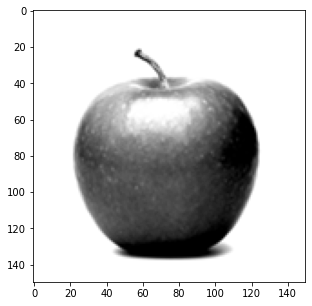

In [16]:
# Bi-Linear Interpolation Algorithm
def bilinear_interpolation(img, scale_factor):
    # Get the dimensions of the image
    height, width = img.shape[:2]
    # Calculate the new dimensions of the image
    new_height = int(height * scale_factor)
    new_width = int(width * scale_factor)
    # Create a new image of the new dimensions
    new_img = np.zeros((new_height, new_width), dtype=np.uint8)
    # Calculate the scaling factor
    scale_x = width / new_width
    scale_y = height / new_height
    # Loop through the new image and find the nearest neighbor in the original image
    for y in range(new_height):
        for x in range(new_width):
            # Calculate the coordinates of the nearest neighbor in the original image
            x0 = int(x * scale_x)
            y0 = int(y * scale_y)
            # Calculate the coordinates of the next nearest neighbor in the original image
            x1 = min(x0 + 1, width - 1)
            y1 = min(y0 + 1, height - 1)
            # Calculate the distances to the nearest neighbors
            dx = (x * scale_x) - x0
            dy = (y * scale_y) - y0
            # Calculate the pixel values of the nearest neighbors
            q11 = img[y0, x0]
            q12 = img[y1, x0]
            q21 = img[y0, x1]
            q22 = img[y1, x1]
            # Calculate the interpolated pixel value
            new_img[y, x] = int((1 - dx) * (1 - dy) * q11 + (1 - dx) * dy * q12 + dx * (1 - dy) * q21 + dx * dy * q22)
    return new_img

#Saving the image in a variable
img = cv2.imread('Graphics/apple.png')

#OpenCV by defualt uses BGR instead of RGB.  Old digital camera standard.
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print(img.shape)

# Set the size of the plot.
fig = plt.figure(figsize = (5,5))

# Draw the image.
plt.imshow(img, cmap='gray')

(450, 450)


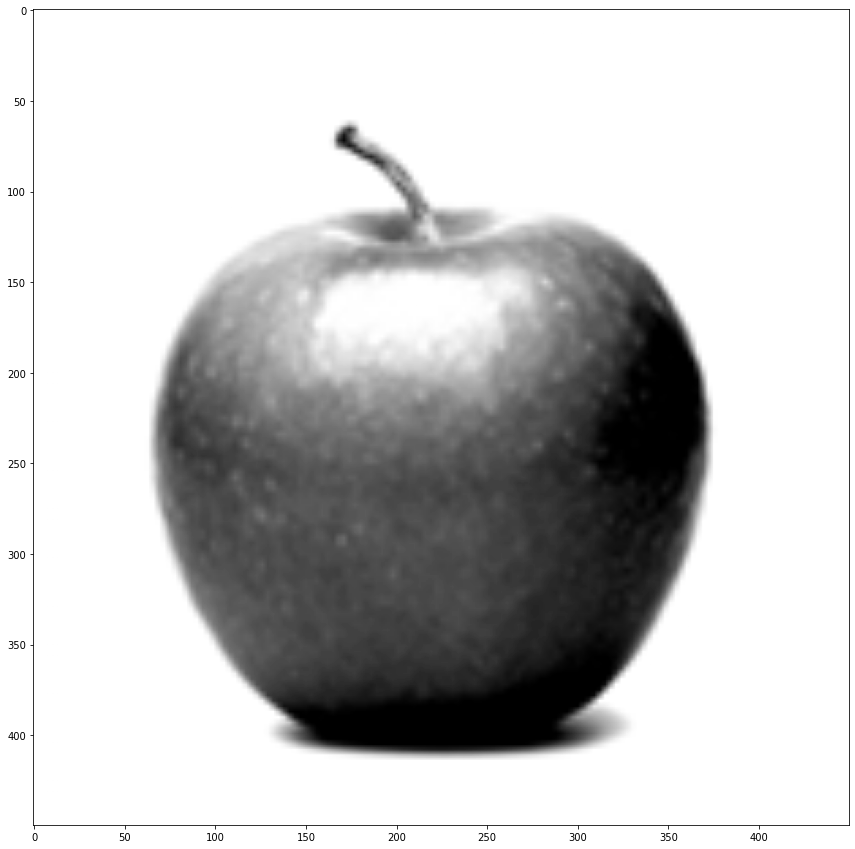

In [17]:
img = bilinear_interpolation(img, 3)
print(img.shape)

# Set the size of the plot.
fig = plt.figure(figsize = (15,15))

plt.imshow(img, cmap='gray')

### BiCubic  

BiLinear Interpolation uses the 4 (2x2 frame) nearest neighbors to find the new pixel value.  Bicubic interpolation uses the 16 nearest neighbors (4x4 frame).

OpenCv uses the following formula to distribute the weights:
````
const float A = -0.75f;

coeffs[0] = ((A*(x + 1) - 5*A)*(x + 1) + 8*A)*(x + 1) - 4*A;
coeffs[1] = ((A + 2)*x - (A + 3))*x*x + 1;
coeffs[2] = ((A + 2)*(1 - x) - (A + 3))*(1 - x)*(1 - x) + 1;
coeffs[3] = 1.f - coeffs[0] - coeffs[1] - coeffs[2];
````

x used in the above code is calculated from below code where x = fx

````
fx = (float)((dx+0.5)*scale_x - 0.5);
sx = cvFloor(fx);
fx -= sx;
````
Let's use the previous example:
<img src="../Graphics/BiLinear_3.png"><p>
<ol>
<li>We previously calculated P1. This time let’s take ‘P2’. First, we find the position of P2 in the input image as we did before. So, we find P2 coordinate as (0.75,0.25) with dx = 1 and dy=0.</li>
<li>Because cubic needs 4 pixels (2 on left and 2 on right) so, we pad the input image.
OpenCV has different methods to add borders which you can check here. Here, I used cv2.BORDER_REPLICATE method.</li>
</ol>

After padding the input image looks like this:

<img src="../Graphics/BiCubic_1.png"><p>

<ol start="3">
<li>To find the value of P2, let’s first visualize where P2 is in the image. Yellow is the input image before padding. We take the blue 4×4 neighborhood as shown below</li>
</ol>

<img src="../Graphics/BiCubic_2.png"><p>

<ol start="4">
<li>For P2, using dx and dy we calculate fx and fy from code above. We get, fx=0.25 and fy=0.75</li>
<li>Now, we substitute fx and fy in the above code to calculate the four coefficients. Thus we get coefficients = [-0.0351, 0.2617,0.8789, -0.1055] for fy =0.75 and for fx=0.25 we get coefficients = [ -0.1055 , 0.8789, 0.2617, -0.0351]</li>
<li>First, we will perform cubic interpolation along rows( as shown in the above figure inside blue box) with the above calculated weights for fx as

-0.1055 *10 + 0.8789*10 + 0.2617*20 -0.0351*20 = 12.265625<br>
-0.1055 *10 + 0.8789*10 + 0.2617*20 -0.0351*20 = 12.265625<br>
-0.1055 *10 + 0.8789*10 + 0.2617*20 -0.0351*20 = 12.265625<br>
-0.1055 *30 + 0.8789*30 + 0.2617*40 -0.0351*40 = 32.265625

</li>
<li>Now, using above calculated 4 values, we will interpolate along columns using calculated weights for fy as
-0.0351*12.265 + 0.2617*12.265 + 0.8789*12.265 -0.1055*32.625 = 10.11702</li>
<li>Similarly, repeat for other pixels.</li>
</ol>

The final result:<br>
<img src="../Graphics/BiCubic_3.png"><p>

This produces noticeably sharper images than the previous two methods and balances processing time and output quality. That’s why it is used widely 

In [ ]:
# Bi-Cubic Interpolation Algorithm
def bicubic_interpolation(img, scale_factor):
    # Get the dimensions of the image
    height, width = img.shape[:2]
    # Calculate the new dimensions of the image
    new_height = int(height * scale_factor)
    new_width = int(width * scale_factor)
    # Create a new image of the new dimensions
    new_img = np.zeros((new_height, new_width), dtype=np.uint8)
    # Calculate the scaling factor
    scale_x = width / new_width
    scale_y = height / new_height
    # Loop through the new image and find the nearest neighbor in the original image
    for y in range(new_height):
        for x in range(new_width):
            # Calculate the coordinates of the nearest neighbor in the original image
            x0 = int(x * scale_x)
            y0 = int(y * scale_y)
            # Calculate the coordinates of the next nearest neighbor in the original image
            x1 = min(x0 + 1, width - 1)
            y1 = min(y0 + 1, height - 1)
            x2 = min(x0 + 2, width - 1)
            y2 = min(y0 + 2, height - 1)
            x3 = min(x0 + 3, width - 1)
            y3 = min(y0 + 3, height - 1)
            # Calculate the distances to the nearest neighbors
            dx = (x * scale_x) - x0
            dy = (y * scale_y) - y0
            # Calculate the pixel values of the nearest neighbors
            q11 = img[y0, x0]
            q12 = img[y1, x0]
            q13 = img[y2, x0]
            q14 = img[y3, x0]
            q21 = img[y0, x1]
            q22 = img[y1, x1]
            q23 = img[y2, x1]
            q24 = img[y3, x1]
            q31 = img[y0, x2]
            q32 = img[y1, x2]
            q33 = img[y2, x2]
            q34 = img[y3, x2]
            q41 = img[y0, x3]
            q42 = img[y1, x3]
            q43 = img[y2, x3]
            q44 = img[y3, x3]
            # Calculate the interpolated pixel value
            new_img[y, x] = int((1/6) * ((-1 * q11 + 3 * q21 - 3 * q31 + q41) * (dx ** 3) + (3 * q11 - 6 * q21 + 3 * q31) * (dx ** 2) + (-3 * q11 + 3 * q31) * dx + (q11 + 4 * q21 + q31)) * (dy ** 3) + ((1 * q12 - 3 * q22 + 3 * q32 - q42) * (dx ** 3) + (-3 * q12 + 6 * q22 - 3 * q32) * (dx ** 2) + (3 * q12 - 3 * q32) * dx + (-q12 - 4 * q22 + q32)) * (dy ** 2) + ((-1 * q13 + 3 * q23 - 3 * q33 + q43) * (dx ** 3) + (3 * q13 - 6 * q23 + 3 * q33) * (dx ** 2) + (-3 * q13 + 3 * q33) * dx + (q13 + 4 * q23 + q33)) * dy + ((1 * q14 - 3 * q24 + 3 * q34 - q44) * (dx ** 3) + (-3 * q14 + 6 * q24 - 3 * q34) * (dx ** 2) + (3 * q14 - 3 * q34) * dx + (-q14 - 4 * q24 + q34)))
    return new_img

